https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns

In [15]:
data_path = 'SAheart.data'

if os.path.exists(data_path):
    os.remove(data_path)
!wget https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data

data = pd.read_csv(data_path)
data = data.drop('row.names', axis=1)
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
data = data.sample(frac=1, random_state=2).reset_index(drop=True)

display(data.describe().round(2))
data.info()
data.head()

--2024-10-09 18:09:10--  https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data
Resolving hastie.su.domains (hastie.su.domains)... 159.89.149.97
Connecting to hastie.su.domains (hastie.su.domains)|159.89.149.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25106 (25K)
Saving to: ‘SAheart.data’

SAheart.data        100%[===================>]  24.52K  --.-KB/s    in 0s      

2024-10-09 18:09:11 (265 MB/s) - ‘SAheart.data’ saved [25106/25106]



,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00,462.00
mean,138.33,3.64,4.74,25.41,0.42,53.10,26.04,17.04,42.82,0.35
std,20.50,4.59,2.07,7.78,0.49,9.82,4.21,24.48,14.61,0.48
min,101.00,0.00,0.98,6.74,0.00,13.00,14.70,0.00,15.00,0.00
25%,124.00,0.05,3.28,19.77,0.00,47.00,22.98,0.51,31.00,0.00
50%,134.00,2.00,4.34,26.12,0.00,53.00,25.80,7.51,45.00,0.00
75%,148.00,5.50,5.79,31.23,1.00,60.00,28.50,23.89,55.00,1.00
max,218.00,31.20,15.33,42.49,1.00,78.00,46.58,147.19,64.00,1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    int64  
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 36.2 KB


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,124,3.04,4.80,19.52,1,60,21.78,147.19,41,1
1,136,7.36,2.19,28.11,1,61,25.00,61.71,54,0
2,124,0.81,6.16,11.61,0,35,21.47,10.49,26,0
3,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
4,162,7.00,7.67,34.34,1,33,30.77,0.00,62,0


In [16]:
# Splitting into features (X) and target (y)
target = 'chd'
X = data.drop(target, axis=1)
y = data[target]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

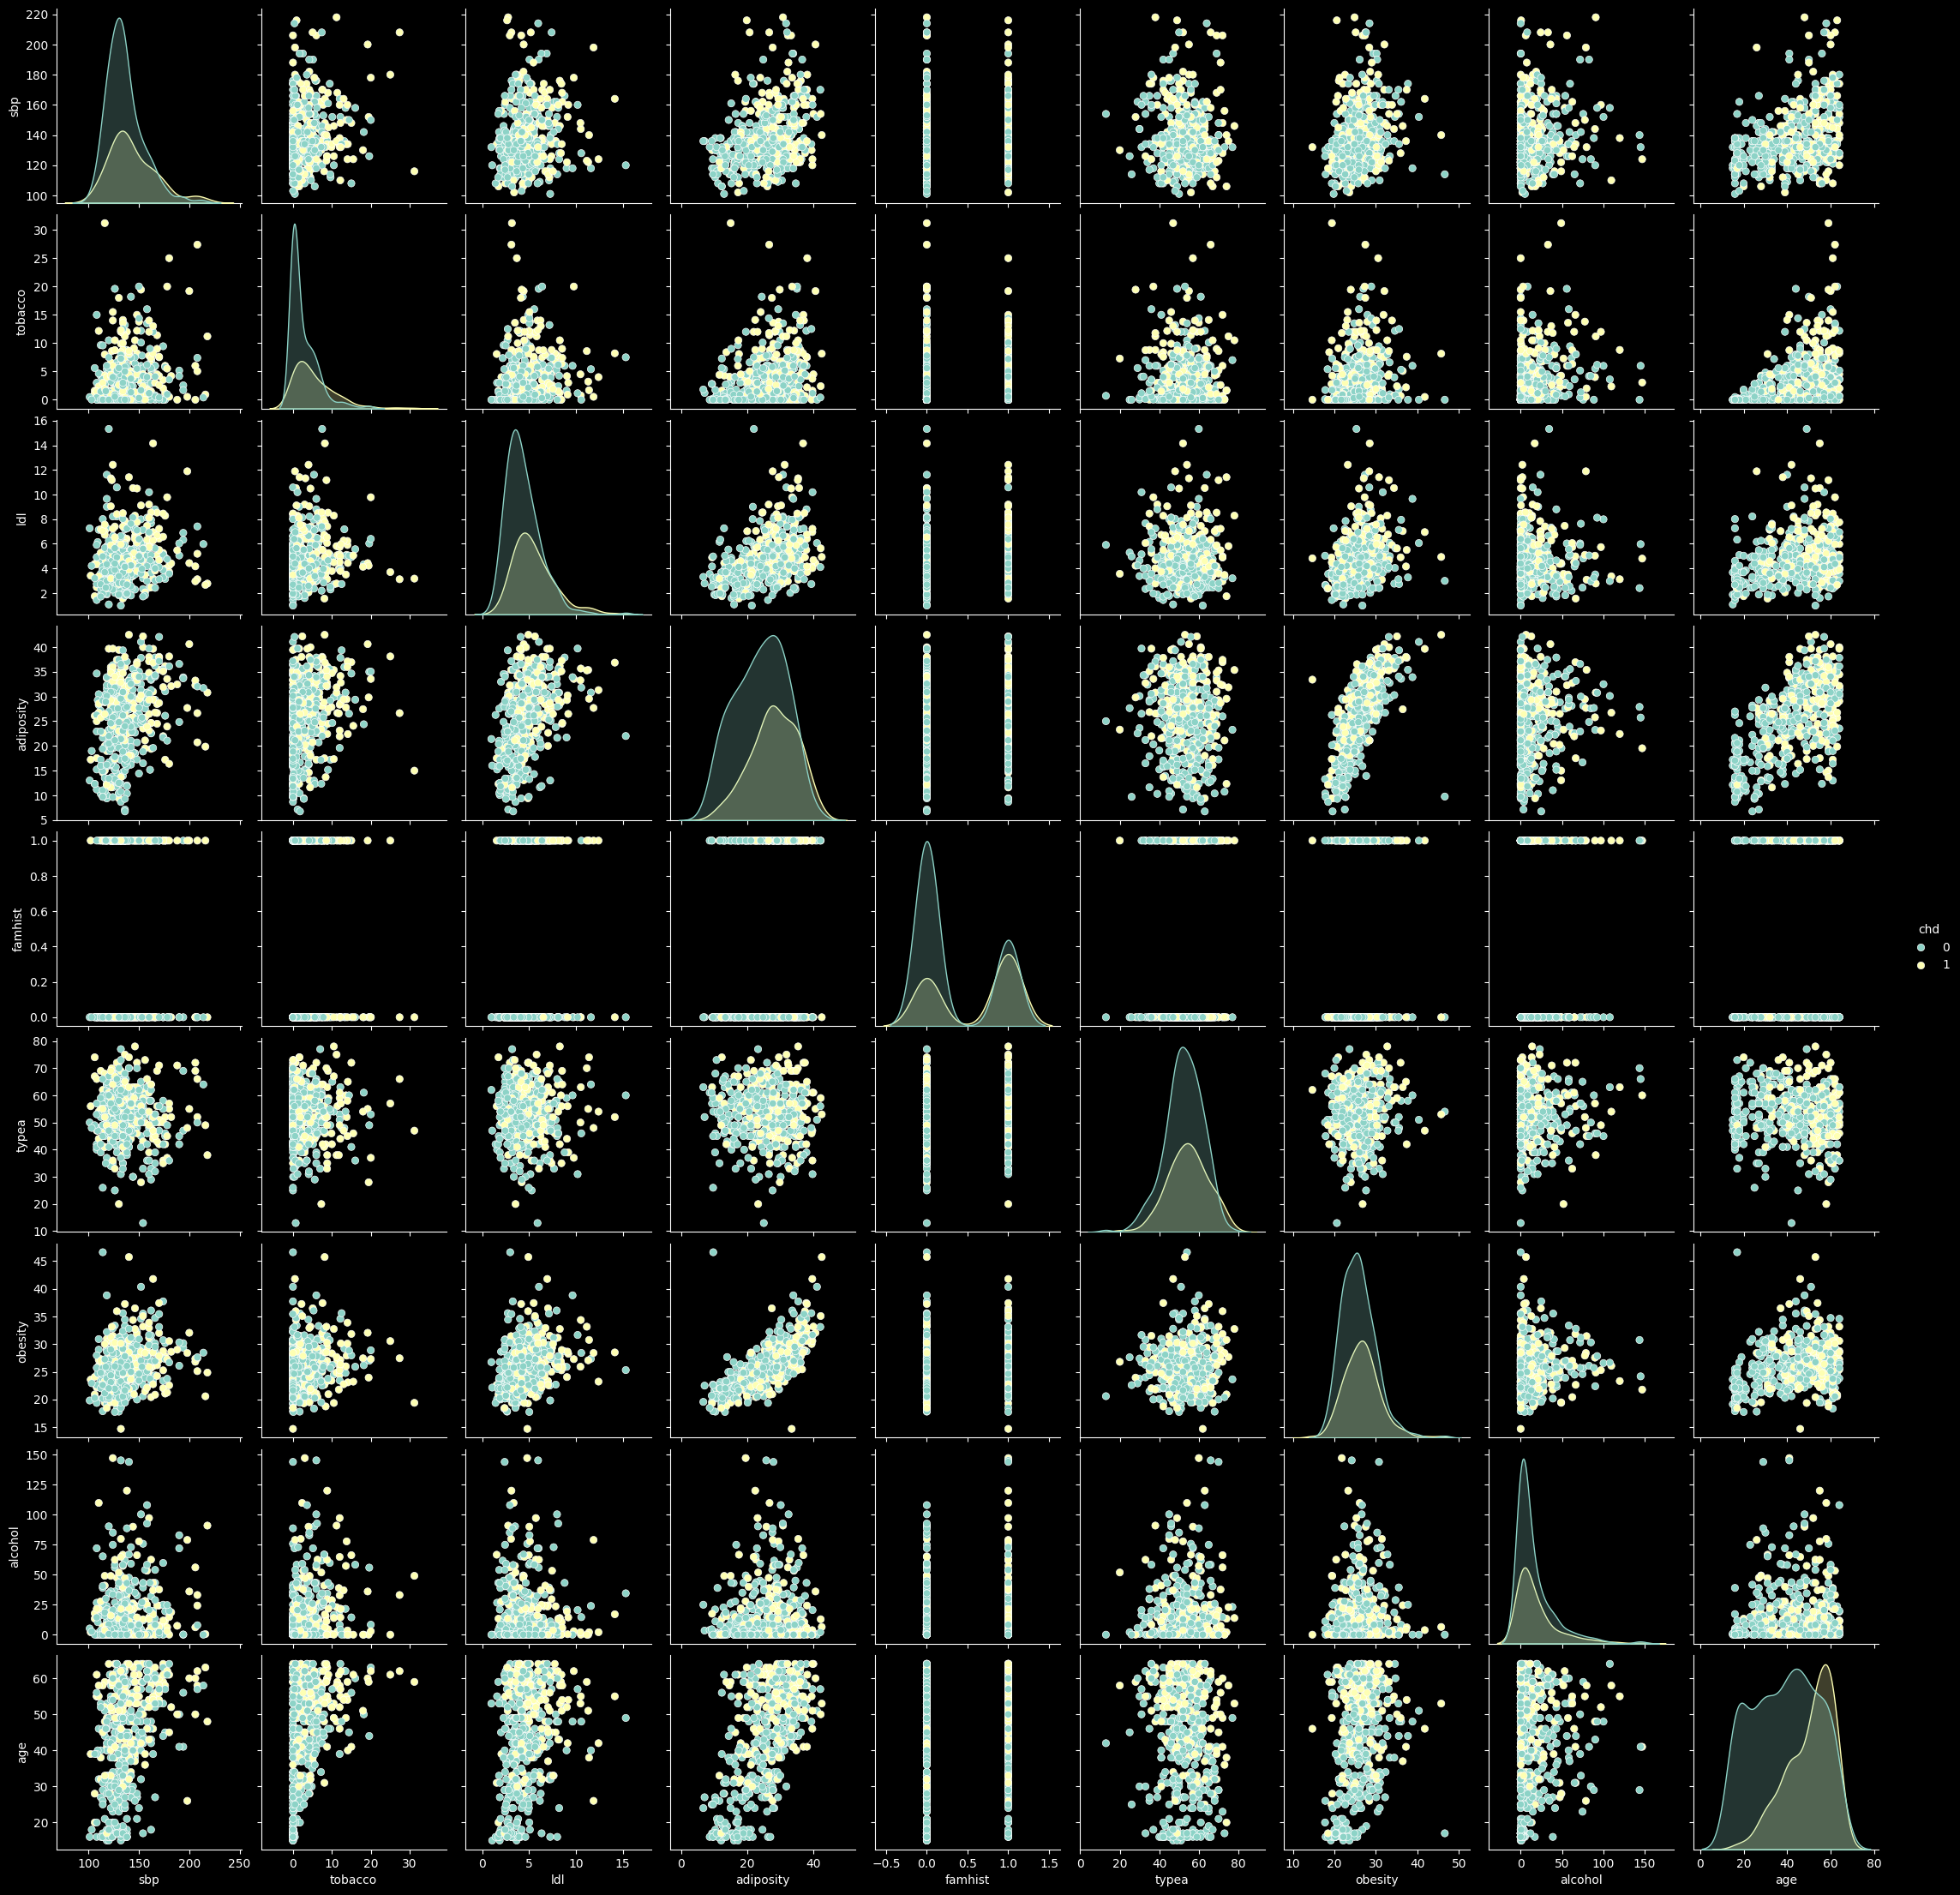

In [17]:
sns.pairplot(data, hue=target) # TODO: replace with manual plotting

In [18]:
# Logistic Regression with SGD (No Regularization)
sgd_model = SGDClassifier(loss='log_loss', penalty='l1', max_iter=1000, random_state=42)
sgd_model.fit(X_train, y_train)

# Validation Accuracy
y_val_pred = sgd_model.predict(X_val)
val_accuracy_no_reg = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy (No Regularization): {val_accuracy_no_reg * 100:.2f}%')

Validation Accuracy (No Regularization): 65.22%


In [19]:
# Logistic Regression with L2 Regularization
sgd_l2_model = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.01, max_iter=1000, random_state=42)
sgd_l2_model.fit(X_train, y_train)

# Validation Accuracy
y_val_pred_l2 = sgd_l2_model.predict(X_val)
val_accuracy_l2_reg = accuracy_score(y_val, y_val_pred_l2)
print(f'Validation Accuracy (L2 Regularization): {val_accuracy_l2_reg * 100:.2f}%')

Validation Accuracy (L2 Regularization): 65.22%


In [20]:
# Forward Stepwise Feature Selection with Cross-Validation
base_model = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.01, max_iter=1000, random_state=42)

# Implement Forward Stepwise Selection
sfs = SequentialFeatureSelector(base_model, direction='forward', n_jobs=-1, scoring='accuracy', cv=5)
sfs.fit(X_train, y_train)

# Features selected and Validation Accuracy
X_train_selected = sfs.transform(X_train)
X_val_selected = sfs.transform(X_val)
base_model.fit(X_train_selected, y_train)
y_val_pred_stepwise = base_model.predict(X_val_selected)
val_accuracy_stepwise = accuracy_score(y_val, y_val_pred_stepwise)
print(f'Validation Accuracy (Stepwise Selection): {val_accuracy_stepwise * 100:.2f}%')


Validation Accuracy (Stepwise Selection): 63.04%


In [21]:
# Test Set Evaluation
# Unregularized model
y_test_pred = sgd_model.predict(X_test)
test_accuracy_no_reg = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy (No Regularization): {test_accuracy_no_reg * 100:.2f}%')

# L2 Regularization model
y_test_pred_l2 = sgd_l2_model.predict(X_test)
test_accuracy_l2_reg = accuracy_score(y_test, y_test_pred_l2)
print(f'Test Accuracy (L2 Regularization): {test_accuracy_l2_reg * 100:.2f}%')

# Stepwise selection model
X_test_selected = sfs.transform(X_test)
y_test_pred_stepwise = base_model.predict(X_test_selected)
test_accuracy_stepwise = accuracy_score(y_test, y_test_pred_stepwise)
print(f'Test Accuracy (Stepwise Selection): {test_accuracy_stepwise * 100:.2f}%')


results = pd.DataFrame({
    "Model": ["Unregularized", "L2 Regularized", "Stepwise Selected"],
    "Validation Accuracy (%)": [val_accuracy_no_reg*100, val_accuracy_l2_reg*100, val_accuracy_stepwise*100],
    "Test Accuracy (%)": [test_accuracy_no_reg*100, test_accuracy_l2_reg*100, test_accuracy_stepwise*100]
})

results

Test Accuracy (No Regularization): 70.21%
Test Accuracy (L2 Regularization): 65.96%
Test Accuracy (Stepwise Selection): 72.34%


,Model,Validation Accuracy (%),Test Accuracy (%)
0,Unregularized,65.217391,70.212766
1,L2 Regularized,65.217391,65.957447
2,Stepwise Selected,63.043478,72.340426
